In [1]:
import pandas as pd
from pathlib import Path
import networkx as nx
from networkx.algorithms import community
from tqdm import tqdm
import numpy as np
import copy
from time import perf_counter
import matplotlib.pyplot as plt
from dotenv import load_dotenv
load_dotenv("./.env.local")
import os
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
import tweepy
client = tweepy.Client(BEARER_TOKEN, wait_on_rate_limit=True)
pd.options.mode.chained_assignment = None  # default='warn'

## Read the edgelists, merge them and store them

In [2]:
def read_edgelist(path, type_of_edges):
    if type_of_edges is not None:
        assert (type_of_edges) == 'liking' or (type_of_edges) == 'retweeters' or (type_of_edges) == 'any', "type_of_edges must be 'liking' or 'retweeters' or 'any'"
    
    if type_of_edges == 'any':
        df =  pd.concat([pd.read_csv(file) for file in Path(path).iterdir()], ignore_index=True)
        df.name = 'any'
    elif type_of_edges == 'liking':
        df =  pd.concat([pd.read_csv(file) for file in Path(path).iterdir() if 'liking' in file.name], ignore_index=True)
        df.name = 'liking'
    elif type_of_edges == 'retweeters':
        df =  pd.concat([pd.read_csv(file) for file in Path(path).iterdir() if 'retweeters' in file.name], ignore_index=True)
        df.name = 'retweeters'
        
    df.drop_duplicates(inplace=True)
    return df

In [3]:
edgelists_any_df = read_edgelist('edgelists', 'any')
edgelists_liking_df = read_edgelist('edgelists', 'liking')
edgelists_retweeters_df = read_edgelist('edgelists', 'retweeters')

edgelists = [edgelists_any_df, edgelists_liking_df, edgelists_retweeters_df]

## Some stats about the networks

In [4]:
def filter_df_by_authors(df, author_ids_sample):
    return df[df['author_id'].isin(author_ids_sample)]

def print_basic_stats(df):
    print('Number of unique authors:', df['author_id'].nunique())
    print('Number of unique users:', df['user_id'].nunique())
    print('Number of nodes:', df['author_id'].nunique() + df['user_id'].nunique())
    print('Number of edges:', df.shape[0])

def common_authors(df1, df2):
    # commun authors between liking and retweeters
    df1_authors = df1['author_id'].unique()
    df2_authors = df2['author_id'].unique()

    authors_in_common = set(df1_authors).intersection(set(df2_authors))

    print('Number of authors in common:', len(authors_in_common))
    return authors_in_common

def common_rows(df1, df2):
    count_common_authors = df1.merge(df2, on=['author_id', 'user_id'], how='inner')
    print('Number of rows in common:', count_common_authors.shape[0])
    return count_common_authors

In [5]:
for df in edgelists:
    print('-----------' + df.name + '-----------')
    print_basic_stats(df)

print("")

common_authors(edgelists_liking_df, edgelists_retweeters_df)
common_rows(edgelists_liking_df, edgelists_retweeters_df)

-----------any-----------
Number of unique authors: 786
Number of unique users: 2790105
Number of nodes: 2790891
Number of edges: 4466776
-----------liking-----------
Number of unique authors: 755
Number of unique users: 2668663
Number of nodes: 2669418
Number of edges: 4245301
-----------retweeters-----------
Number of unique authors: 682
Number of unique users: 520160
Number of nodes: 520842
Number of edges: 787529

Number of authors in common: 651
Number of rows in common: 566054


,user_id,author_id
0,2909381990,716152735
1,3101577272,2222395582
2,1378730257184919559,2222395582
3,755116981649453056,2222395582
4,1252569115098636290,2222395582
...,...,...
566049,1314894413814996992,554497503
566050,788945381480464386,554497503
566051,1486117700657164297,554497503
566052,39666268,554497503


## Sampling !Might not be representative!

In [7]:
common_authors_list = common_authors(edgelists_liking_df, edgelists_retweeters_df)
# get a sample of common_authors_list, to reduce the graph size
author_ids_sample = np.random.choice(list(common_authors_list), size=50, replace=False)

# filter df by author_ids
edgelists_any_df_sample = filter_df_by_authors(edgelists_any_df, author_ids_sample)
edgelists_liking_df_sample = filter_df_by_authors(edgelists_liking_df, author_ids_sample)
edgelists_retweeters_df_sample = filter_df_by_authors(edgelists_retweeters_df, author_ids_sample)

# print basic stats
print('----------- sample any -----------')
print_basic_stats(edgelists_any_df_sample)
print('----------- sample liking -----------')
print_basic_stats(edgelists_liking_df_sample)
print('----------- sample retweeters -----------')
print_basic_stats(edgelists_retweeters_df_sample)

print("")
common_authors(edgelists_liking_df_sample, edgelists_retweeters_df_sample)
common_rows(edgelists_liking_df_sample, edgelists_retweeters_df_sample)

# rename "user_id" to "Source" and "author_id" to "Target"
edgelists_any_df_sample = edgelists_any_df_sample.rename(columns={'user_id': 'Source', 'author_id': 'Target'})
edgelists_liking_df_sample = edgelists_liking_df_sample.rename(columns={'user_id': 'Source', 'author_id': 'Target'})
edgelists_retweeters_df_sample = edgelists_retweeters_df_sample.rename(columns={'user_id': 'Source', 'author_id': 'Target'})

Path.mkdir(Path("analysisDemo"), exist_ok=True)
edgelists_any_df_sample.to_csv('analysisDemo/edgelists_any_sample.csv', index=False, header=True)
edgelists_liking_df_sample.to_csv('analysisDemo/edgelists_liking_sample.csv', index=False, header=True)
edgelists_retweeters_df_sample.to_csv('analysisDemo/edgelists_retweeters_sample.csv', index=False, header=True)

Number of authors in common: 651
----------- sample any -----------
Number of unique authors: 50
Number of unique users: 668625
Number of nodes: 668675
Number of edges: 708757
----------- sample liking -----------
Number of unique authors: 50
Number of unique users: 631448
Number of nodes: 631498
Number of edges: 668696
----------- sample retweeters -----------
Number of unique authors: 50
Number of unique users: 141102
Number of nodes: 141152
Number of edges: 147685

Number of authors in common: 50
Number of rows in common: 107624


## Load the data and create NetworkX graphs

In [8]:
edgelists = {
    'any': edgelists_any_df_sample,
    'like': edgelists_liking_df_sample,
    'retweet': edgelists_retweeters_df_sample
}

nx_graphs = {}

for name, edgelist in edgelists.items():
    tmp_nx_graph = nx.from_pandas_edgelist(edgelist, source='Source', target='Target', create_using=nx.Graph())
    # Ensure that graphs have a 'weight' edge attribute
    nx.set_edge_attributes(tmp_nx_graph, 1, 'weight')
    nx_graphs[name] = tmp_nx_graph

## Louvain

In [9]:
# Louvain implementation
def louvain(G, npassage):
    # Will contain the graph and the communities after each passage
    data = {}
    for i in range(0, npassage):
        print(f"Passage {i+1}", flush=True)
        G, communities, get_community = louvain_step(G, i==0)
        data[i] = get_community
        print(f"There are {len(communities)} communities after passage {i+1}", flush=True)
    return data


def louvain_step(G, is_first_passage):
    # Step 1: Initialization, start with each node being a single community
    communities = {idx: set([node]) for idx, node in enumerate(G.nodes)}
    # To get direct access to the community (it speeds up a bit the algorithm)
    get_community = {node: idx for idx, node in enumerate(G.nodes)}
    # Used in the modularity computation
    neighbors_sets = {node: set(G.neighbors(node)) for node in G.nodes}
    m = len(G.edges)

    # Sum the weights of the incident edges for all nodes inside a community, for all communities
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        sum_communities = {idx: sum(dict(G.degree(community)).values()) for idx, community in communities.items()}
    else:
        sum_communities = {idx: sum(dict(G.degree(community, 'weight')).values()) for idx, community in communities.items()}

    prev_communities = {}
    i = 0
    # While there are changes in the communities, make another iteration
    while(communities != prev_communities):
        print(f"Iteration {i+1}", flush=True)
        # Deepcopy to have a new object with a new reference
        # Otherwise comparison in while is always True
        prev_communities = copy.deepcopy(communities)
        
        for node in tqdm(G.nodes):
            # Step 2: Remove node from its community
            neighboring_communities = get_neighboring_communities(G, node, get_community)
            if neighboring_communities == set():
                continue
            belong_to = get_community[node]
            communities[belong_to].remove(node)
            sum_communities[belong_to] -= G.degree(node, 'weight')
            if communities[belong_to] == set():
                del communities[belong_to]
                del sum_communities[belong_to]

            # Step 3: Insert the node in the community that maximizes the modularity
            scores = [
                (neighbor_community, modularity_gain(G, node, communities[neighbor_community], sum_communities[neighbor_community], neighbors_sets[node], m, is_first_passage))
                for neighbor_community in neighboring_communities
            ]
            best_community, best_score = max(scores, key=lambda x: x[1])
            communities[best_community].add(node)
            get_community[node] = best_community
            sum_communities[best_community] += G.degree(node, 'weight')
          
        i += 1

    # Step 4: Update the graph
    if is_first_passage:
        return get_new_graph(G, communities, sum_communities, get_community), communities, get_community
    return get_new_graph(G, communities, sum_communities, get_community), communities, get_community


def get_neighboring_communities(G, node, get_community):
    # Use a set to make sure a community only appear once
    neighboring_communities = set()
    for neighbor in G.neighbors(node):
        if neighbor == node: continue
        neighboring_communities.add(get_community[neighbor])
    return neighboring_communities


def modularity_gain(G, node, community, sum_community, neighbor_set, m, is_first_passage):
    # Separate first passage and other ones to speed up the algorithm
    if is_first_passage:
        # Sum the weights of the edges from node into community nodes
        # Using sets allow to use intersection()
        sum_weights_node = len(neighbor_set.intersection(community))
        right_member = (sum_community * G.degree[node]) / (2 * (m**2))
    else:
        # Sum the weights of the edges from node into community nodes
        sum_weights_node = sum([G.get_edge_data(node, member)['weight'] for member in G.neighbors(node) if member in community])
        right_member = (sum_community * G.degree(node, 'weight')) / (2 * (m**2))
    # Compute modularity
    left_member = sum_weights_node / (2 * m)
    return left_member - right_member


def get_new_graph(old_G, communities, sum_communities, get_community):
    print("Constructing new graph", flush=True)
    G = nx.Graph()
    G.add_nodes_from(communities.keys())
    for community in communities:
        G.add_edge(community, community, weight=sum_communities[community])

    for source, dest, weight_dict in old_G.edges(data=True):
        community1 = get_community[source]
        community2 = get_community[dest]
        # If edge not exist, weight initialized at 0
        current_weight = G.get_edge_data(community1, community2, {'weight': 0})['weight']
        new_weight = current_weight + weight_dict['weight']
        G.add_edge(community1, community2, weight=new_weight)
    return G

In [10]:
results = {}
for name, G in nx_graphs.items():
    if name != 'any':
        continue
    print(f"Louvain on {name}")
    data = louvain(G, 2)
    results[name] = data
    print(f"\n")

Louvain on any
Passage 1
Iteration 1


100%|████████████████████████████████████████████████████| 668640/668640 [00:08<00:00, 78095.45it/s]

Iteration 2



100%|████████████████████████████████████████████████████| 668640/668640 [00:07<00:00, 90816.29it/s]

Iteration 3



100%|████████████████████████████████████████████████████| 668640/668640 [00:07<00:00, 92914.61it/s]

Constructing new graph


There are 50 communities after passage 1
Passage 2
Iteration 1


100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 20153.30it/s]

Iteration 2



100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 22701.36it/s]

Iteration 3



100%|█████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 9264.27it/s]

Iteration 4



100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12006.37it/s]

Iteration 5



100%|████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 12146.84it/s]

Constructing new graph
There are 20 communities after passage 2




## Export and save label communities of each node (for Gephi)

In [11]:
df_results = {}
# Get the label communities for the nodes for each passage
for name, result in results.items():
    intermediate_results = []

    for i in range(len(result)-1, -1, -1):
        if i == 0:
            break
        curr = result[i]
        prev = result[i-1]
        intermediate_result =  {node: curr[val] for node, val in prev.items()}
        intermediate_results.append(intermediate_result)
    
    try:
        commu = intermediate_results[-1]
    # If we run only for one passage
    except IndexError:
        commu = result[0]

    communities_df = pd.DataFrame(commu.items(), columns=['Id', 'Community'])
    communities_df["Label"] = communities_df["Id"].map(lambda x: x)
    communities_df["Is_author"] = False

    communities_df.loc[communities_df['Id'].isin(edgelists[name]['Target'].unique()), "Is_author"] = True
    communities_df.to_csv(f"analysisDemo/communities_{name}.csv", index=False)

    df_results[name] = communities_df

## Some stats

In [12]:
n = {}
biggest_communities = {}
for name, result in df_results.items():
    n[name] = len(result['Id'].unique())
    print(f"Number of nodes in {name}: {n[name]}")
    
print('---------------------------------------------------------------------------')
# Number of nodes for each community
for name, result in df_results.items():
    print(name)
    print(result.groupby('Community')["Id"].count().sort_values(ascending=False))
    print('\n')
    print(name)
    df_percent = result.groupby('Community')["Id"].count().sort_values(ascending=False).div(n[name]).mul(100)
    print(df_percent[:15])
    biggest_communities[name] = list(df_percent[:3].index)
    print('\n')
    print('---------------------------------------------------------------------------')

Number of nodes in any: 668640
---------------------------------------------------------------------------
any
Community
28    318846
40    227602
48    106103
44      5658
49      3455
34      1592
27      1419
39      1352
21      1307
43      1148
15       107
38        21
9         12
25         9
46         2
47         2
4          2
35         1
45         1
17         1
Name: Id, dtype: int64


any
Community
28    47.685750
40    34.039543
48    15.868479
44     0.846195
49     0.516721
34     0.238095
27     0.212222
39     0.202201
21     0.195471
43     0.171692
15     0.016003
38     0.003141
9      0.001795
25     0.001346
46     0.000299
Name: Id, dtype: float64


---------------------------------------------------------------------------


## Plots

any


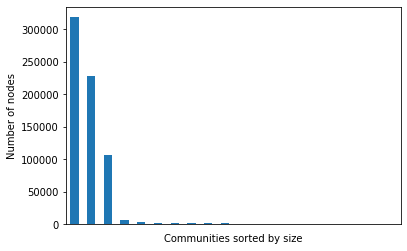

In [13]:
# Bar plot of the number of nodes in each community
for name, result in df_results.items():
    result.groupby('Community')["Id"].count().sort_values(ascending=False).plot(kind='bar')
    plt.xticks(color='w')
    plt.tick_params(bottom=False)
    plt.xlabel("Communities sorted by size", labelpad=-10)
    plt.ylabel("Number of nodes")
    plt.savefig(f"analysis/nodes_in_each_community_{name}.pdf", bbox_inches='tight')
    print(name)
    plt.show()

## Analyze only the authors from the results

In [14]:
df_results_only_authors = {}
n_unique_only_authors = {}

for name, result in df_results.items():
    df_results_only_authors[name] = result[result['Is_author'] == True]
    n_unique_only_authors[name] = len(df_results_only_authors[name]['Id'].unique())
    print(f"Number of unique authors in {name} only authors: {n_unique_only_authors[name]}")

Number of unique authors in any only authors: 50


In [15]:
authors_info = {}

# create a list of all the authors and call the Twitter API
for name, result in df_results_only_authors.items():
    temp_result = result
    authors = list(result["Id"].unique())
    temp_df = pd.DataFrame()
    # split df by 100
    for i in range(0, len(authors), 100):
        print(f"{name}: Iteration {i}-{i+100} / {len(authors)}")
        df_100 = authors[i:i+100]
        res = client.get_users(ids=df_100, user_fields=["public_metrics", "verified"])
        for user_detail in res.data:
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'Username'] = user_detail['username']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'Verified'] = user_detail['verified']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'followers_count'] = user_detail['public_metrics']['followers_count']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'following_count'] = user_detail['public_metrics']['following_count']
            temp_result.loc[temp_result['Id'] == user_detail['id'], 'tweet_count'] = user_detail['public_metrics']['tweet_count']
    temp_df = pd.concat(
        [temp_df, temp_result], ignore_index=True)
    authors_info[name] = temp_df

any: Iteration 0-100 / 50


## Retrieve authors info for the biggest communities

In [16]:
authors_info['any'][authors_info['any']['Community'] == biggest_communities['any'][0]]

,Id,Community,Label,Is_author,Username,Verified,followers_count,following_count,tweet_count
3,904047154997719040,28,904047154997719040,True,techz_dave,False,1056.0,35.0,2364.0
13,213276262,28,213276262,True,RARAmusictweet,False,475.0,1428.0,1095.0
15,868670948,28,868670948,True,LeoVenez,False,1407.0,5002.0,19540.0
21,1925004564,28,1925004564,True,casciatowriting,False,2481.0,2869.0,118640.0
22,1383902579650809867,28,1383902579650809867,True,_Scorpion_11,False,674.0,683.0,10613.0
